In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [9]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files


def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict


def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [10]:
base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
disease = ['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

tcga_files = getTCGA(disease)
tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
tcga_raw = readGCP(tcga_files, mean=True)

In [11]:
# combine samples
tcga_raw = pd.concat(tcga_raw.values())

## LINCS

In [12]:
lincs_path = '/srv/nas/mk2/projects/pan-cancer/LINCS/GSE70138/processed'
lincs = pd.read_pickle(os.path.join(lincs_path, "phase2_mean_rep.pkl"))
lincs_row = pd.read_pickle(os.path.join(lincs_path, "phase2_mean_row.pkl"))
lincs_col = pd.read_pickle(os.path.join(lincs_path, "phase2_mean_col.pkl"))

In [13]:
tcga_down = tcga_raw.loc[:,tcga_raw.columns.isin(lincs_col['pr_gene_symbol'])]

# Model

### Experimental Setup

In [15]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Disease':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [16]:
from dutils import Experiment
# Define experiment
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 index='CGHubAnalysisID',
                 cases='Case ID',
                 min_samples=20)
# Holdout metastatic
exp.holdout(holdout=['SKCM:Metastatic'])
# Train / Test split
exp.train_test_split(cases='Case ID')
# Return data 
train_data, train_labels = exp.get_data(tcga_down, subset="train", dtype=np.float32)
test_data, test_labels = exp.get_data(tcga_down, subset="test", dtype=np.float32)

## Normalization

In [17]:
UpperQuartileTransformer = FunctionTransformer(uq_norm)
Log1PTransformer = FunctionTransformer(np.log1p)

In [18]:
preprocess = make_pipeline(UpperQuartileTransformer, Log1PTransformer)

In [19]:
train_data_norm = pd.DataFrame(preprocess.fit_transform(train_data),
                               index=train_data.index,
                               columns=train_data.columns)
test_data_norm = pd.DataFrame(preprocess.transform(test_data),
                              index=test_data.index,
                              columns=test_data.columns)

In [20]:
exp.meta_data['meta'].value_counts()
exp.holdout_meta['meta'].value_counts()

BRCA:Primary Tumor          1119
KIRC:Primary Tumor           542
LUAD:Primary Tumor           536
THCA:Primary Tumor           502
PRAD:Primary Tumor           501
BRCA:Solid Tissue Normal     114
SKCM:Primary Tumor           103
KIRC:Solid Tissue Normal      72
LUAD:Solid Tissue Normal      59
THCA:Solid Tissue Normal      58
PRAD:Solid Tissue Normal      52
SKCM:Metastatic                0
Name: meta, dtype: int64

SKCM:Metastatic             367
THCA:Solid Tissue Normal      0
THCA:Primary Tumor            0
SKCM:Primary Tumor            0
PRAD:Solid Tissue Normal      0
PRAD:Primary Tumor            0
LUAD:Solid Tissue Normal      0
LUAD:Primary Tumor            0
KIRC:Solid Tissue Normal      0
KIRC:Primary Tumor            0
BRCA:Solid Tissue Normal      0
BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [21]:
# Inspect class split distributions
target = 'meta'
case_counts = exp.meta_data[target].value_counts()
exp.train_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts
exp.test_meta[target].value_counts()[case_counts.index.to_numpy()] / case_counts

BRCA:Primary Tumor          0.796247
KIRC:Primary Tumor          0.809963
LUAD:Primary Tumor          0.805970
THCA:Primary Tumor          0.798805
PRAD:Primary Tumor          0.806387
BRCA:Solid Tissue Normal    0.728070
SKCM:Primary Tumor          0.757282
KIRC:Solid Tissue Normal    0.777778
LUAD:Solid Tissue Normal    0.898305
THCA:Solid Tissue Normal    0.913793
PRAD:Solid Tissue Normal    0.788462
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

BRCA:Primary Tumor          0.203753
KIRC:Primary Tumor          0.190037
LUAD:Primary Tumor          0.194030
THCA:Primary Tumor          0.201195
PRAD:Primary Tumor          0.193613
BRCA:Solid Tissue Normal    0.271930
SKCM:Primary Tumor          0.242718
KIRC:Solid Tissue Normal    0.222222
LUAD:Solid Tissue Normal    0.101695
THCA:Solid Tissue Normal    0.086207
PRAD:Solid Tissue Normal    0.211538
SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [22]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
from tcga_datasets import SiameseDataset
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

Cuda is available: True


# Siamese Network

In [23]:
siamese_train_dataset = SiameseDataset(data=train_data_norm,
                                       labels=train_labels,
                                       train=True)
siamese_test_dataset = SiameseDataset(data=test_data_norm,
                                      labels=test_labels,
                                      train=False)

In [24]:
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss, TripletLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.train_data.shape
embedding_net = EmbeddingNet(n_features, 2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=976, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [25]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2931 (0%)]	Loss: 0.311480
Train: [736/2931 (25%)]	Loss: 0.104826
Train: [1472/2931 (50%)]	Loss: 0.059183
Train: [2208/2931 (75%)]	Loss: 0.041997
Epoch: 1/10. Train set: Average loss: 0.0622
Epoch: 1/10. Validation set: Average loss: 0.0408
Train: [0/2931 (0%)]	Loss: 0.034363
Train: [736/2931 (25%)]	Loss: 0.051448
Train: [1472/2931 (50%)]	Loss: 0.037258
Train: [2208/2931 (75%)]	Loss: 0.036985
Epoch: 2/10. Train set: Average loss: 0.0401
Epoch: 2/10. Validation set: Average loss: 0.0302
Train: [0/2931 (0%)]	Loss: 0.057756
Train: [736/2931 (25%)]	Loss: 0.037472
Train: [1472/2931 (50%)]	Loss: 0.035765
Train: [2208/2931 (75%)]	Loss: 0.023985
Epoch: 3/10. Train set: Average loss: 0.0309
Epoch: 3/10. Validation set: Average loss: 0.0358
Train: [0/2931 (0%)]	Loss: 0.022595
Train: [736/2931 (25%)]	Loss: 0.030395
Train: [1472/2931 (50%)]	Loss: 0.025735
Train: [2208/2931 (75%)]	Loss: 0.025235
Epoch: 4/10. Train set: Average loss: 0.0273
Epoch: 4/10. Validation set: Average loss: 0.0271


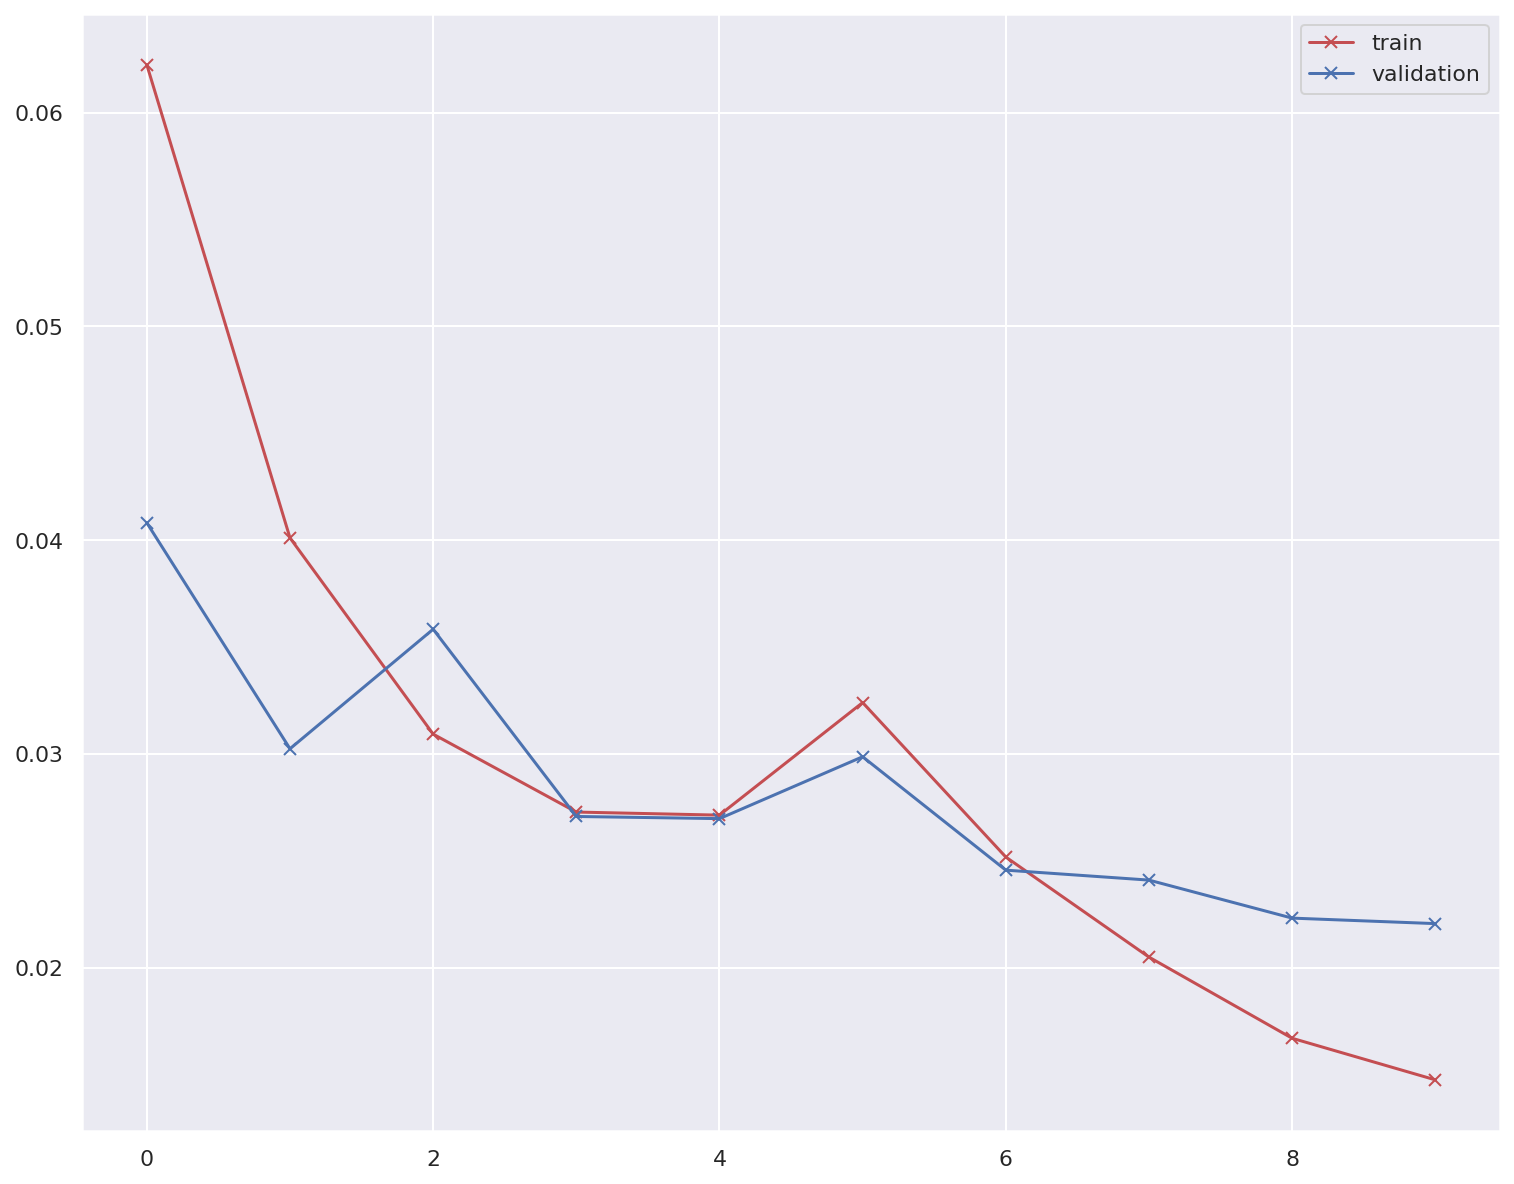

In [26]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

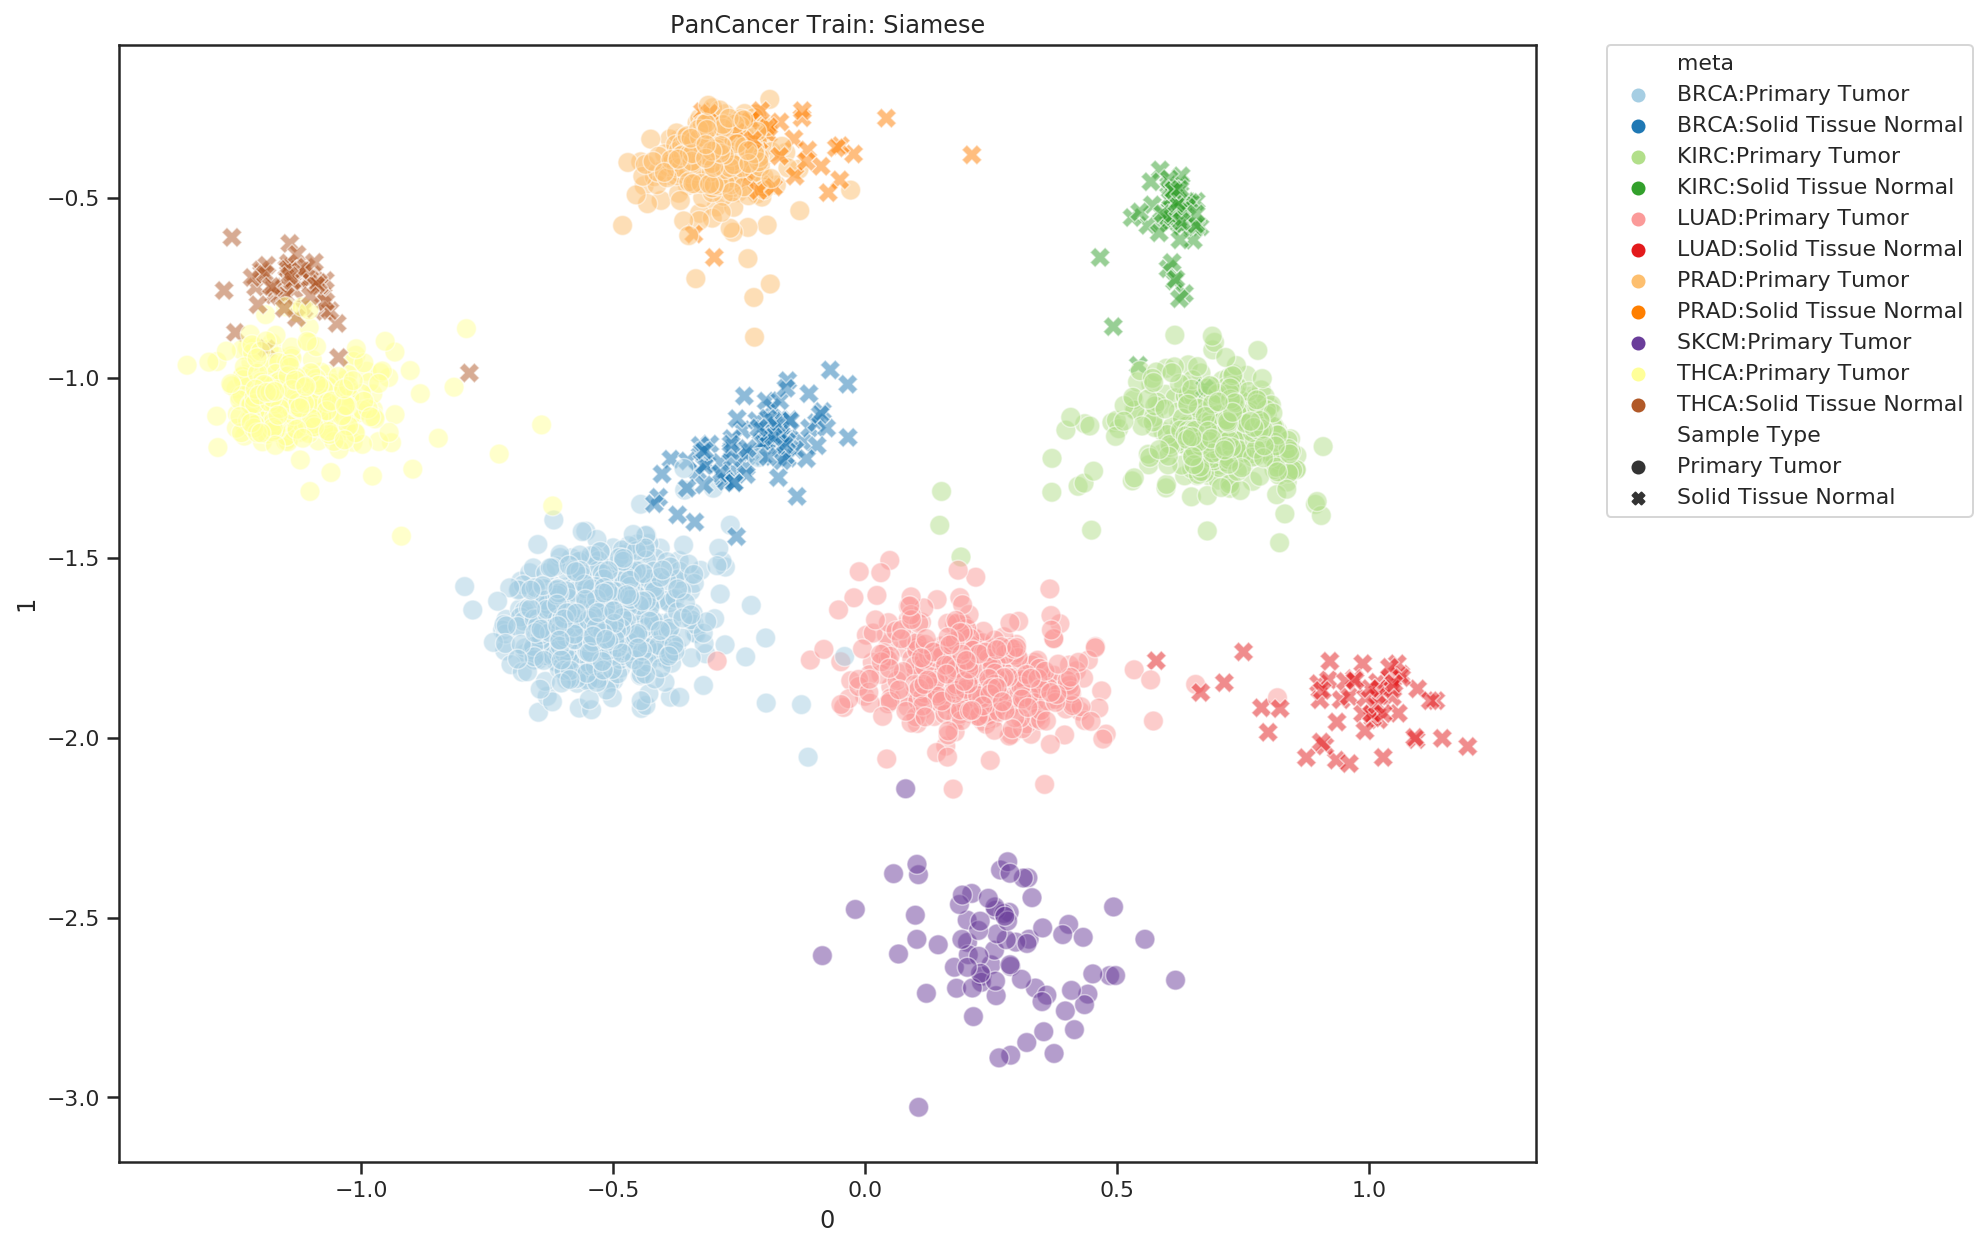

In [27]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(siamese_train_dataset.train_data, siamese_train_dataset.labels, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Train: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

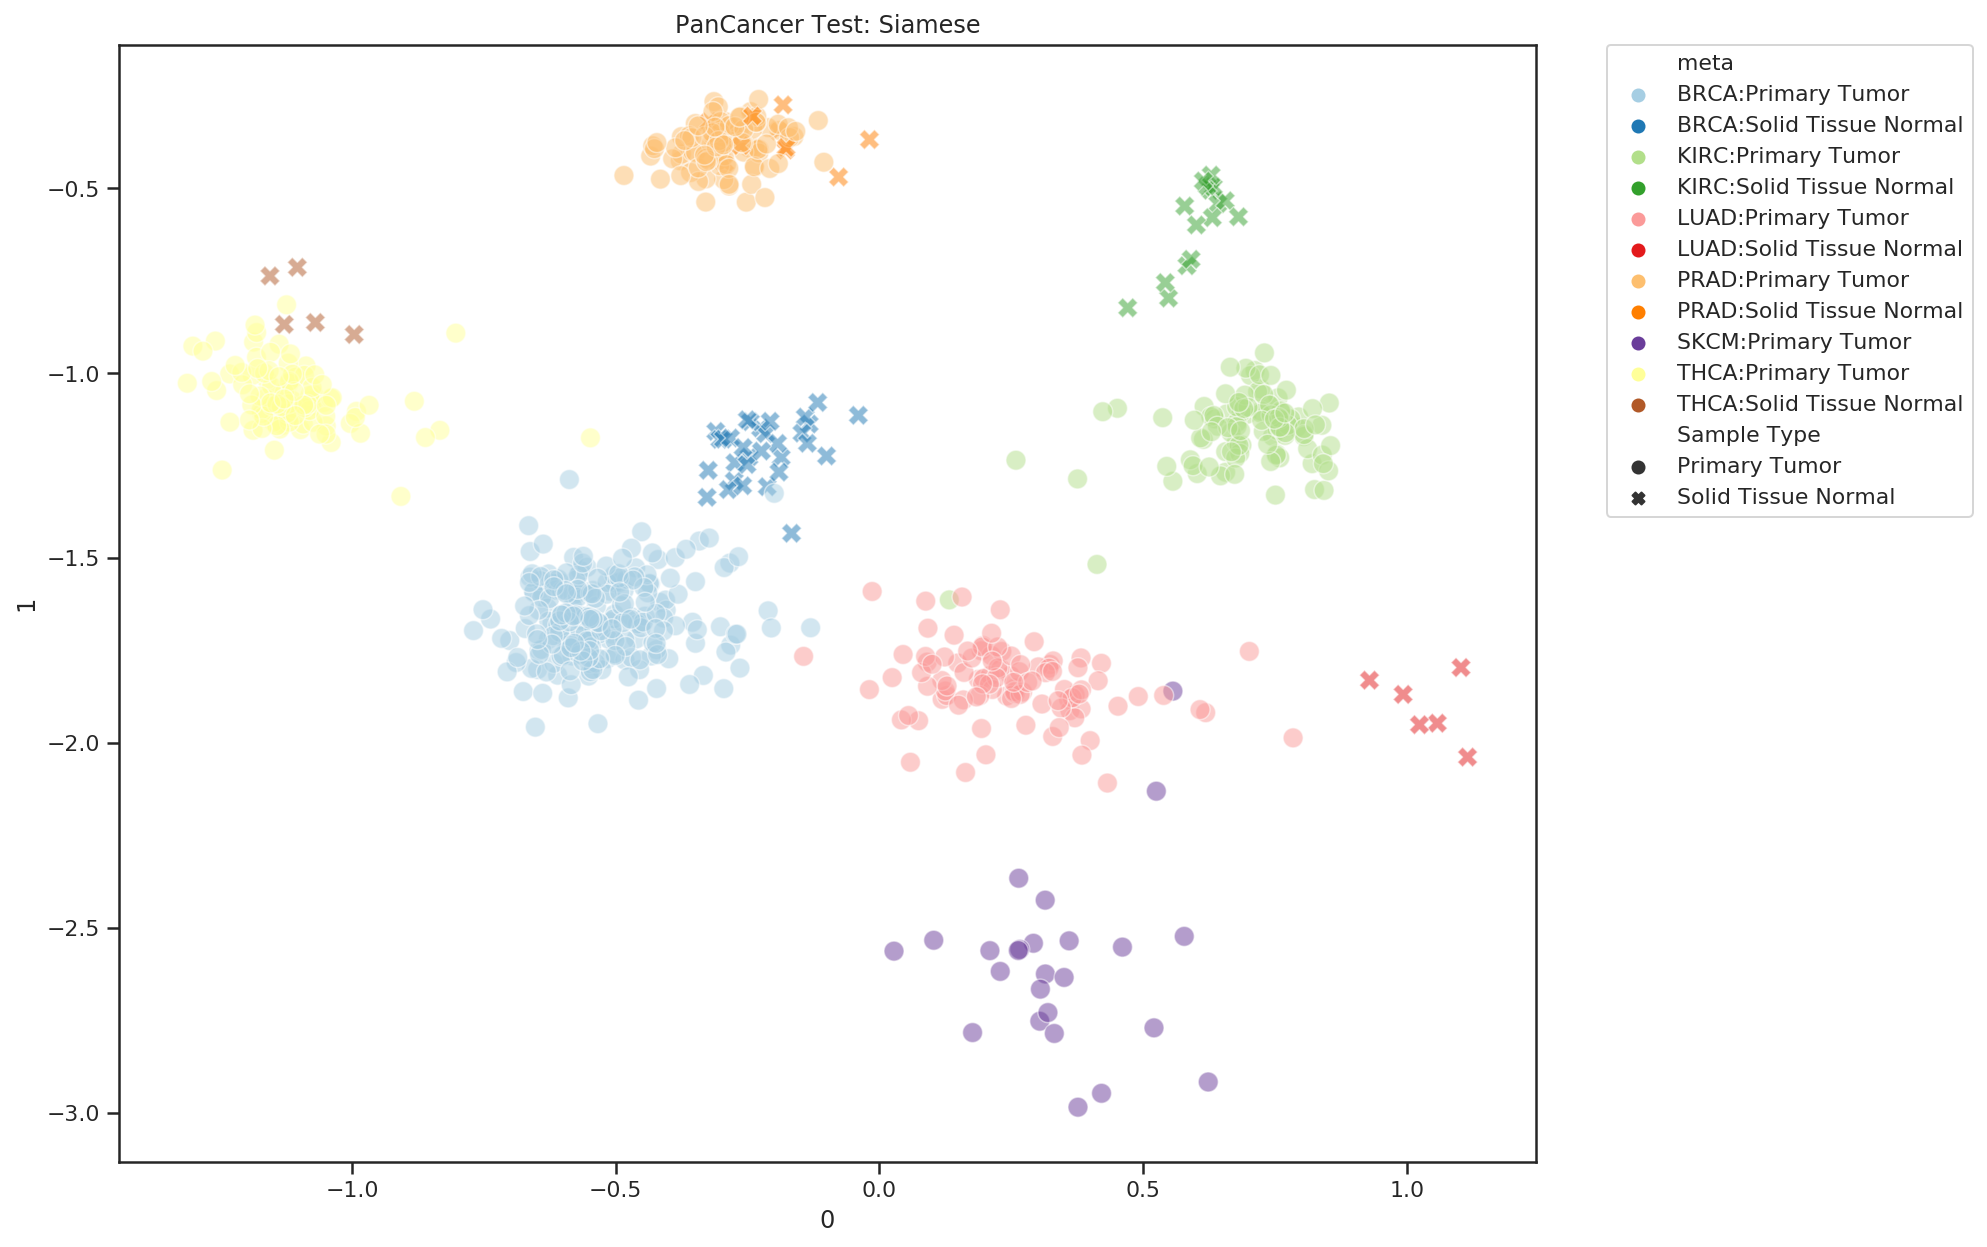

In [28]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Test: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [29]:
holdout_data, holdout_labels = exp.get_data(tcga_down, subset="holdout", dtype=np.float32)
holdout_data = pd.DataFrame(preprocess.transform(holdout_data),
                            index=holdout_data.index,
                            columns=holdout_data.columns)
siamese_holdout_dataset = SiameseDataset(data=holdout_data,
                                         labels=holdout_labels,
                                         train=True)

Text(0.5, 1.0, 'PanCancer Holdout: SKCM:Metastatic')

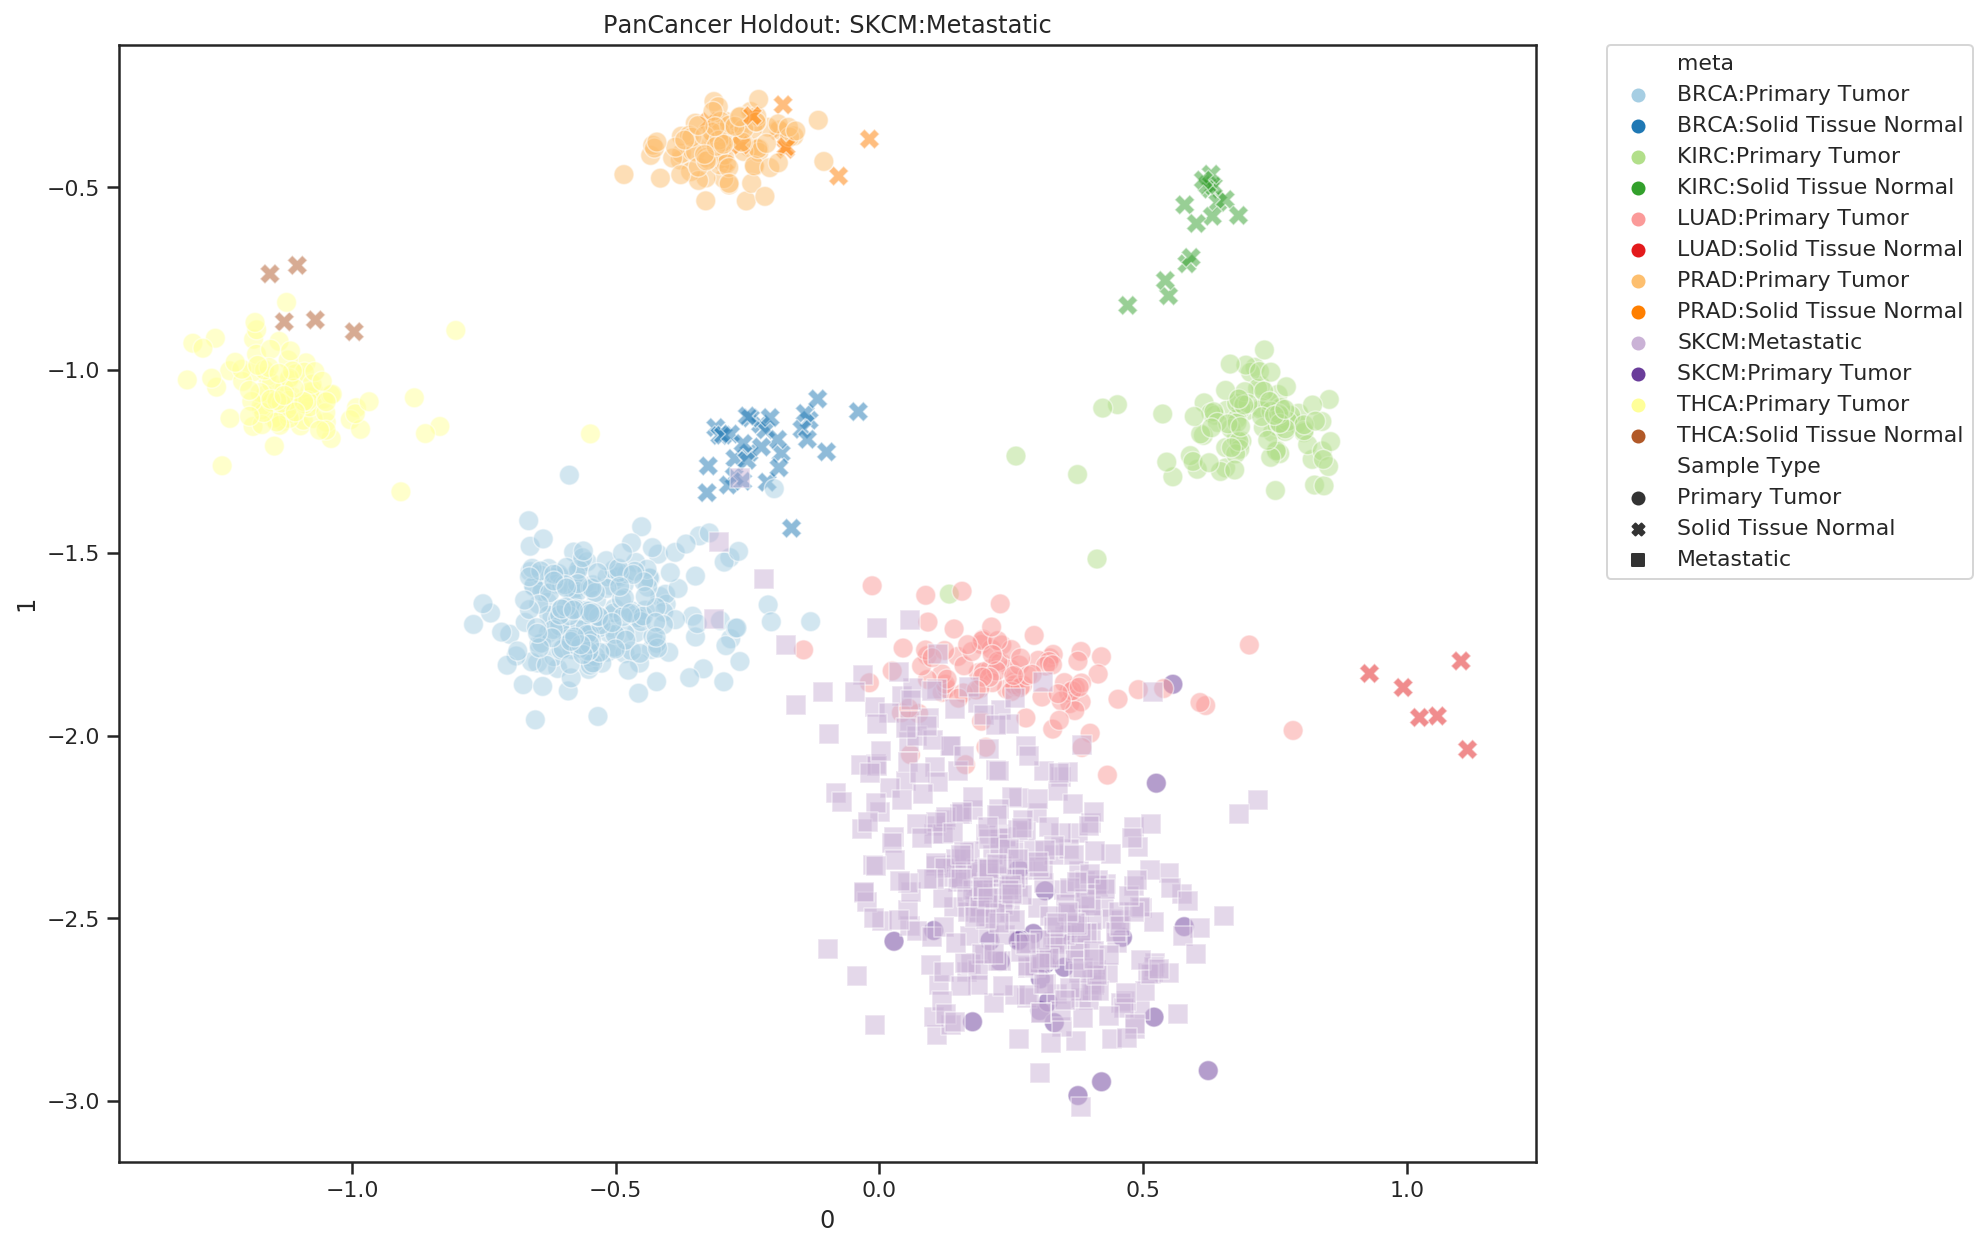

In [30]:
holdout_embeddings_baseline, holdout_labels_baseline = vis.extract_embeddings(siamese_holdout_dataset.train_data, siamese_holdout_dataset.labels, model)
# combine with validation for plotting
comb_embeddings_baseline = np.concatenate((val_embeddings_baseline, holdout_embeddings_baseline))
comb_labels_baseline = np.concatenate((val_labels_baseline, holdout_labels_baseline))
vis.sns_plot_embeddings(comb_embeddings_baseline, comb_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.title('PanCancer Holdout: SKCM:Metastatic')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Clinical Info for Annotation

In [31]:
skcm_clinical = pd.read_csv("../../data/TCGA/clinical/skcm/https:/api.gdc.cancer.gov/data/58cbbc07-5ec4-47c7-9295-11ccbf7693f4/nationwidechildrens.org_clinical_patient_skcm.txt", 
                            sep="\t")
# remove extra header
skcm_clinical = skcm_clinical.loc[2:, :].reset_index(drop=True)
skcm_clinical.shape

(470, 65)

In [32]:
skcm_metas_dist = skcm_clinical[skcm_clinical['metastatic_tumor_site'] == 'Lung']
skcm_metas_dist.shape

(5, 65)

In [33]:
bool_skcm_metas_dist = exp.holdout_meta['Case ID'].isin(skcm_metas_dist['bcr_patient_barcode'])
bool_skcm_metas_dist.sum()

5

Text(0.5, 1.0, 'PanCancer Metastatic: Siamese')

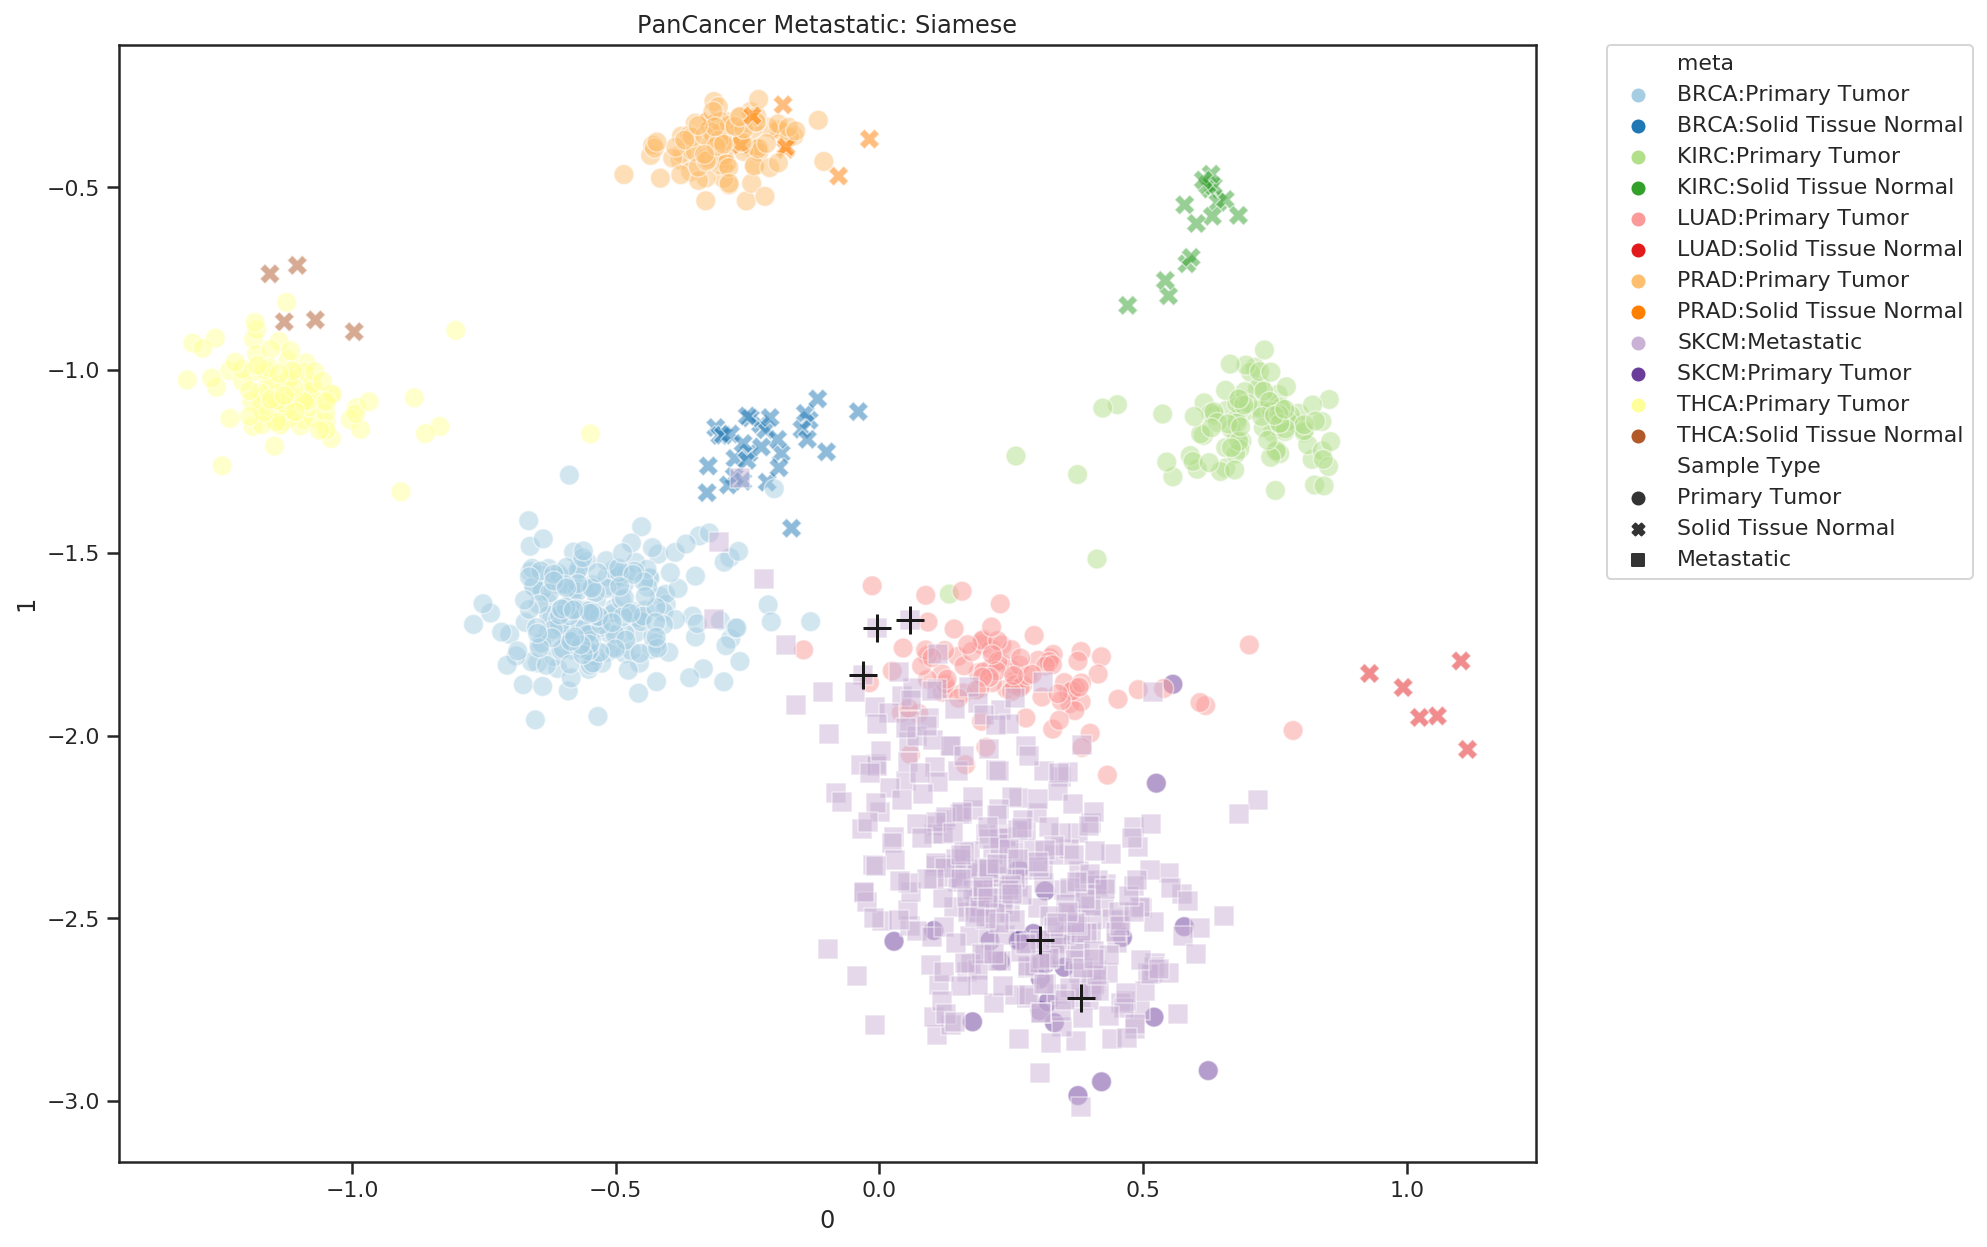

In [34]:
vis.sns_plot_embeddings(comb_embeddings_baseline, comb_labels_baseline, exp.labels_dict, 
                        hue='meta', style='Sample Type', alpha=0.5)
plt.scatter(holdout_embeddings_baseline[bool_skcm_metas_dist,0], 
            holdout_embeddings_baseline[bool_skcm_metas_dist,1],
            marker="+", color='k', s=200)
plt.title('PanCancer Metastatic: Siamese')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## CCLE Data for Projection

In [35]:
ccle_file = [os.path.join(base, "CCLE/CCLE_counts.tsv.gz")]

In [36]:
ccle_meta = pd.read_csv(os.path.join(base, "CCLE/CCLE_GDC_Metadata.tsv.gz"), sep="\t")

In [37]:
ccle = readGCP(ccle_file, biotype='protein_coding', mean=True)

In [38]:
# combine samples
ccle = pd.concat(ccle.values())

In [39]:
ccle.shape

(934, 19594)

In [43]:
ccle = ccle.loc[:,ccle.columns.isin(lincs_col['pr_gene_symbol'])]
ccle.shape

(934, 976)

In [44]:
# normalization
ccle = preprocess.transform(ccle)

In [45]:
# rename ids to match DepMap 'stripped cell line name'
ccle_ids = ["".join(filter(str.isalnum, i[1])).upper() for i in ccle.index.str.split(".")]
ccle.index = ccle_ids
# drop duplicately named cell lines
ccle = ccle.reset_index().drop_duplicates('index').set_index('index')

In [46]:
# DepMap CCLE metadata
ccle_meta = pd.read_csv('/srv/nas/mk2/projects/pan-cancer/DepMap/CCLE/sample_info_v2.csv', sep=",")

In [47]:
ccle_hierarchy = OrderedDict({'disease':['Breast Cancer', 'Lung Cancer', 'Kidney Cancer', 'Thyroid Cancer', 'Prostate Cancer', 'Skin Cancer'],
                              'primary_or_metastasis':['Primary', 'Metastasis']})

In [48]:
ccle_meta.shape
ccle_meta = ccle_meta[ccle_meta['stripped_cell_line_name'].isin(ccle.index)]
ccle_meta.shape

(1775, 24)

(881, 24)

In [49]:
# Define experiment
ccle_exp = Experiment(meta_data=ccle_meta,
                      hierarchy=ccle_hierarchy,
                      index='stripped_cell_line_name',
                      cases='CCLE_Name',
                      min_samples=1)

In [50]:
ccle_exp.holdout(holdout=ccle_exp.labels_dict.values())

In [51]:
ccle_data, ccle_labels = ccle_exp.get_data(ccle, subset="holdout", dtype=np.float32)
siamese_ccle_dataset = SiameseDataset(data=ccle_data,
                                         labels=ccle_labels,
                                         train=True)

In [52]:
ccle_embeddings_baseline, ccle_labels_baseline = vis.extract_embeddings(siamese_ccle_dataset.train_data, siamese_ccle_dataset.labels, model)

In [53]:
# vis.sns_plot_embeddings(ccle_embeddings_baseline, ccle_labels_baseline, ccle_exp.labels_dict, 
#                         hue='meta', style='Sample Type', alpha=0.5)
# plt.title('PanCancer CCLE Projection')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Visualize

In [54]:
tcga_embeddings = pd.DataFrame(val_embeddings_baseline, columns=[0, 1])
tcga_embeddings['id'] = exp.test_meta.index.values
tcga_embeddings['meta'] = exp.test_meta['meta'].values
tcga_embeddings['source'] = np.repeat('TCGA', len(tcga_embeddings))
tcga_embeddings['size'] = np.repeat(20, len(tcga_embeddings))

In [55]:
ccle_embeddings = pd.DataFrame(ccle_embeddings_baseline, columns=[0, 1])
ccle_embeddings['id'] = ccle_exp.holdout_meta.index.values
ccle_embeddings['meta'] = ccle_exp.holdout_meta['meta'].values
ccle_embeddings['source'] = np.repeat('CCLE', len(ccle_embeddings))
ccle_embeddings['size'] = np.repeat(70, len(ccle_embeddings))

In [56]:
all_embeddings = pd.concat([tcga_embeddings, ccle_embeddings])
all_embeddings.shape

(1029, 6)

In [57]:
ccle_exp.holdout

dict_values(['Breast Cancer:Metastasis', 'Breast Cancer:Primary', 'Kidney Cancer:Metastasis', 'Kidney Cancer:Primary', 'Lung Cancer:Metastasis', 'Lung Cancer:Primary', 'Prostate Cancer:Metastasis', 'Skin Cancer:Metastasis', 'Skin Cancer:Primary', 'Thyroid Cancer:Metastasis', 'Thyroid Cancer:Primary'])

Text(0.5, 1.0, 'PanCancer CCLE Projection')

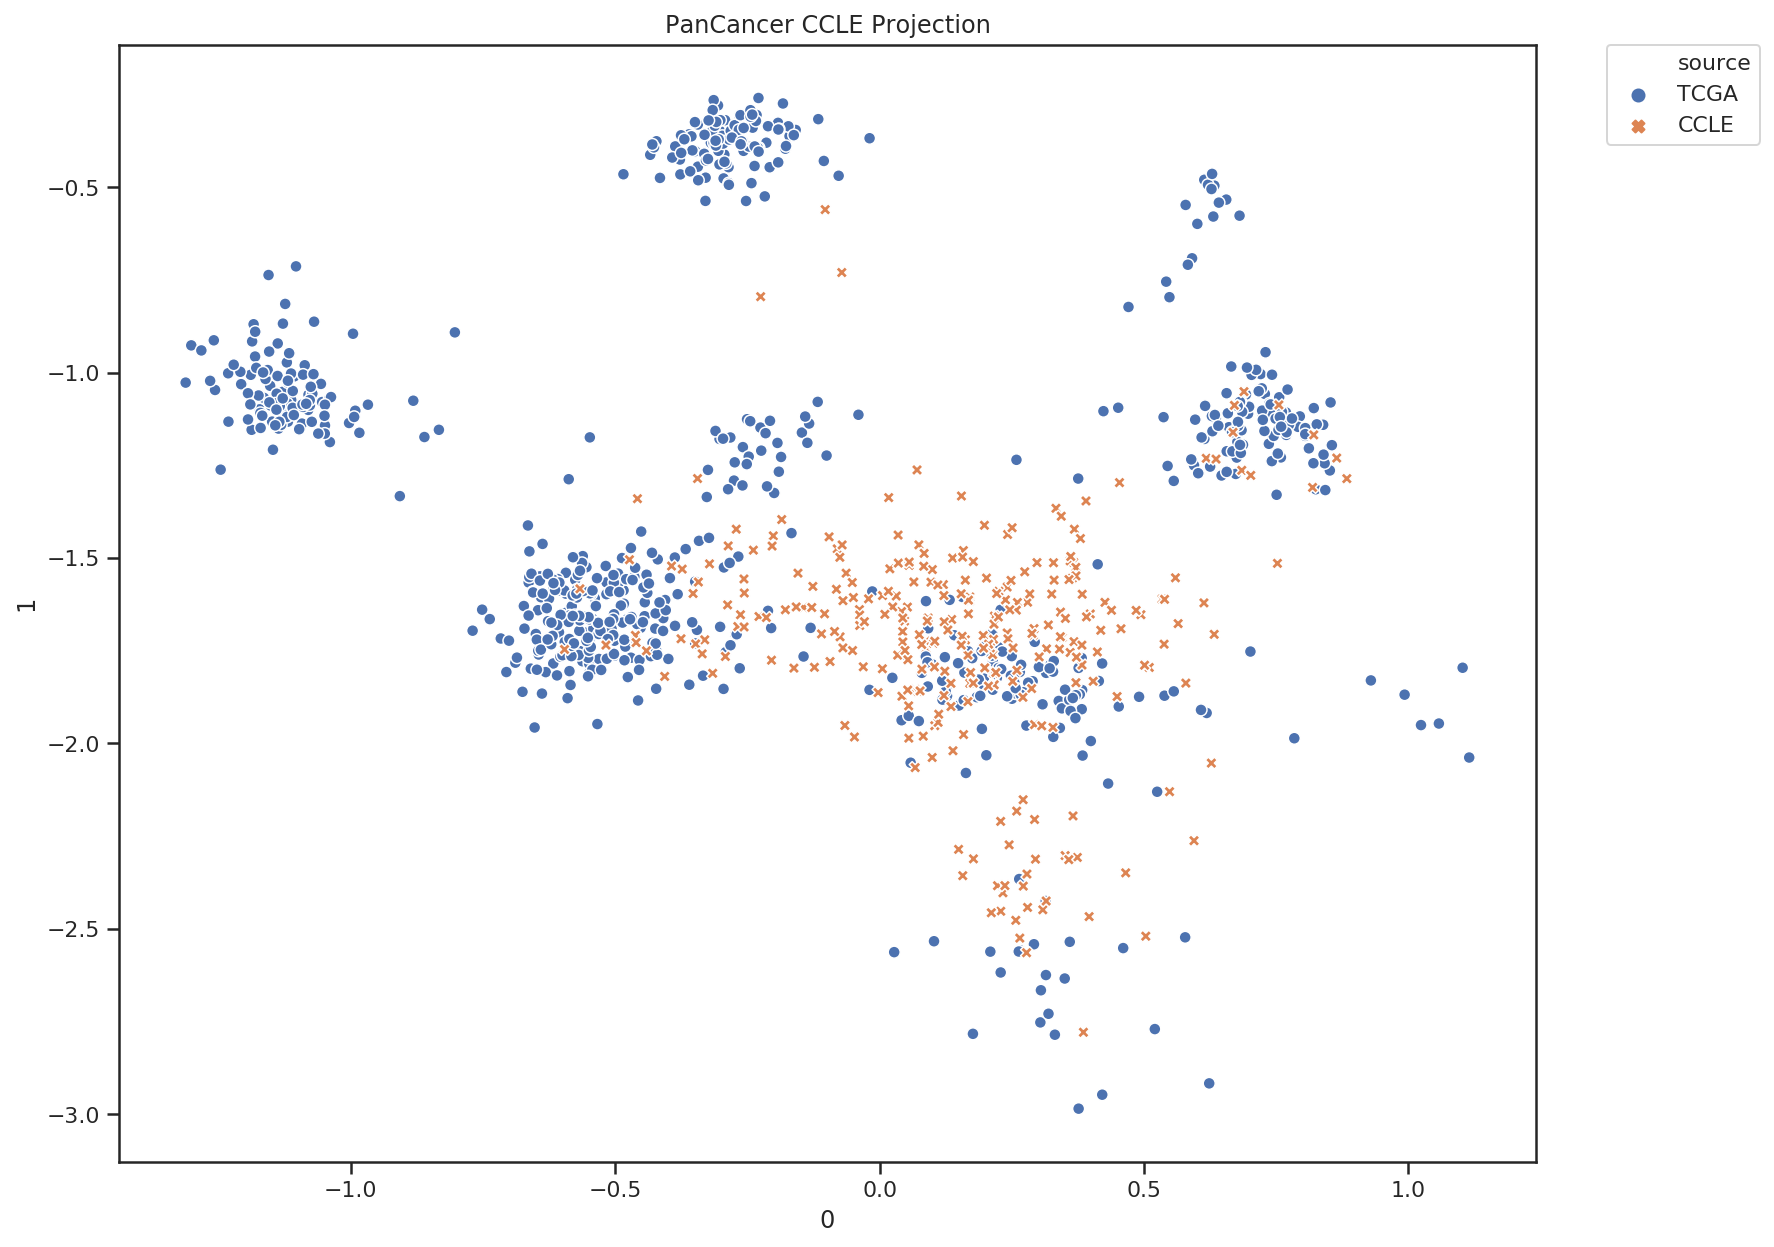

In [58]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(ccle_exp.holdout), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='source', style='source', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 1.0, 'PanCancer CCLE Projection')

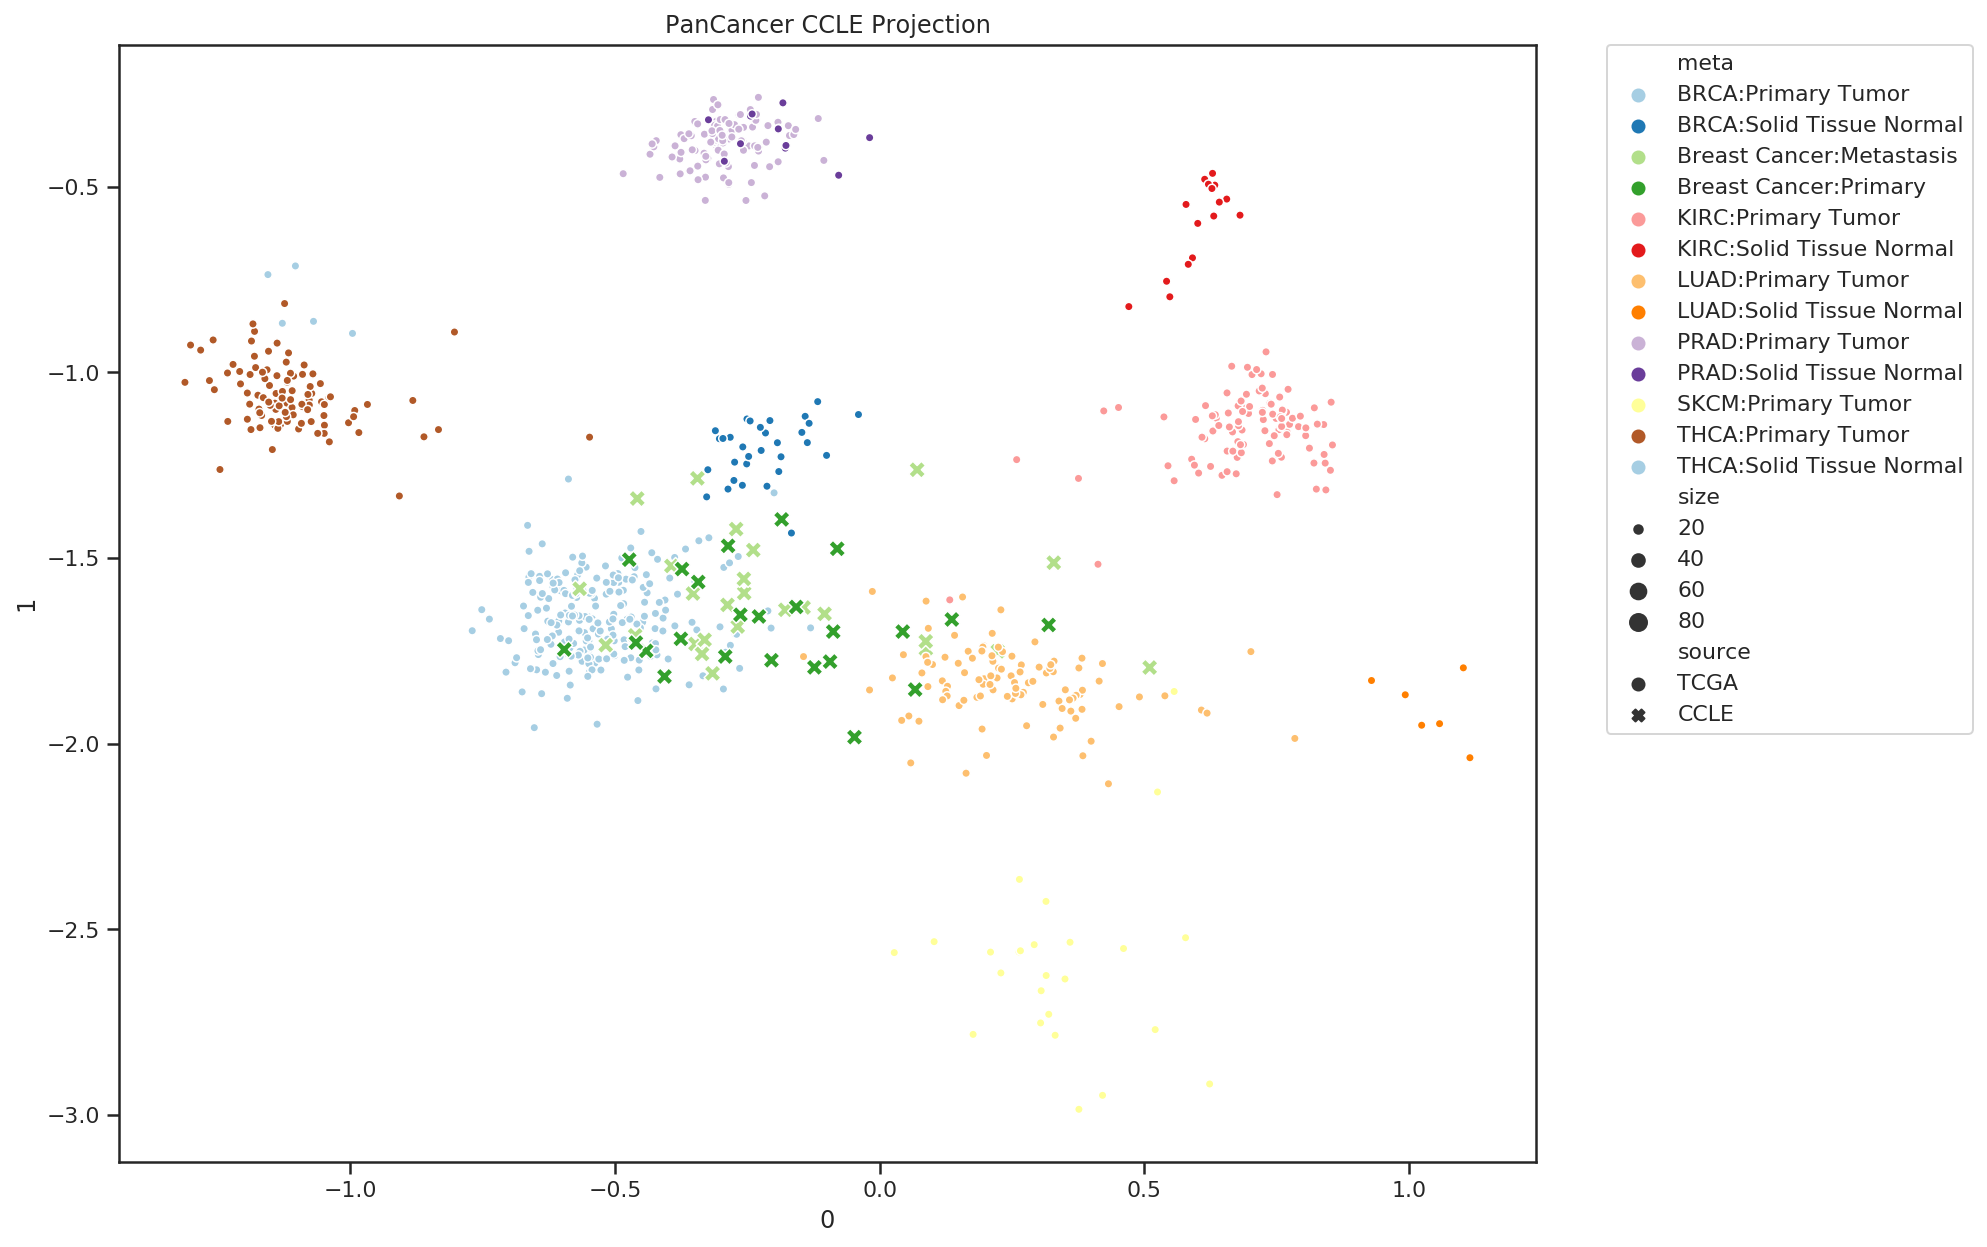

In [59]:
keep = ["Breast Cancer:Primary", "Breast Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [60]:
list(ccle_exp.holdout)

['Breast Cancer:Metastasis',
 'Breast Cancer:Primary',
 'Kidney Cancer:Metastasis',
 'Kidney Cancer:Primary',
 'Lung Cancer:Metastasis',
 'Lung Cancer:Primary',
 'Prostate Cancer:Metastasis',
 'Skin Cancer:Metastasis',
 'Skin Cancer:Primary',
 'Thyroid Cancer:Metastasis',
 'Thyroid Cancer:Primary']

Text(0.5, 1.0, 'PanCancer CCLE Projection')

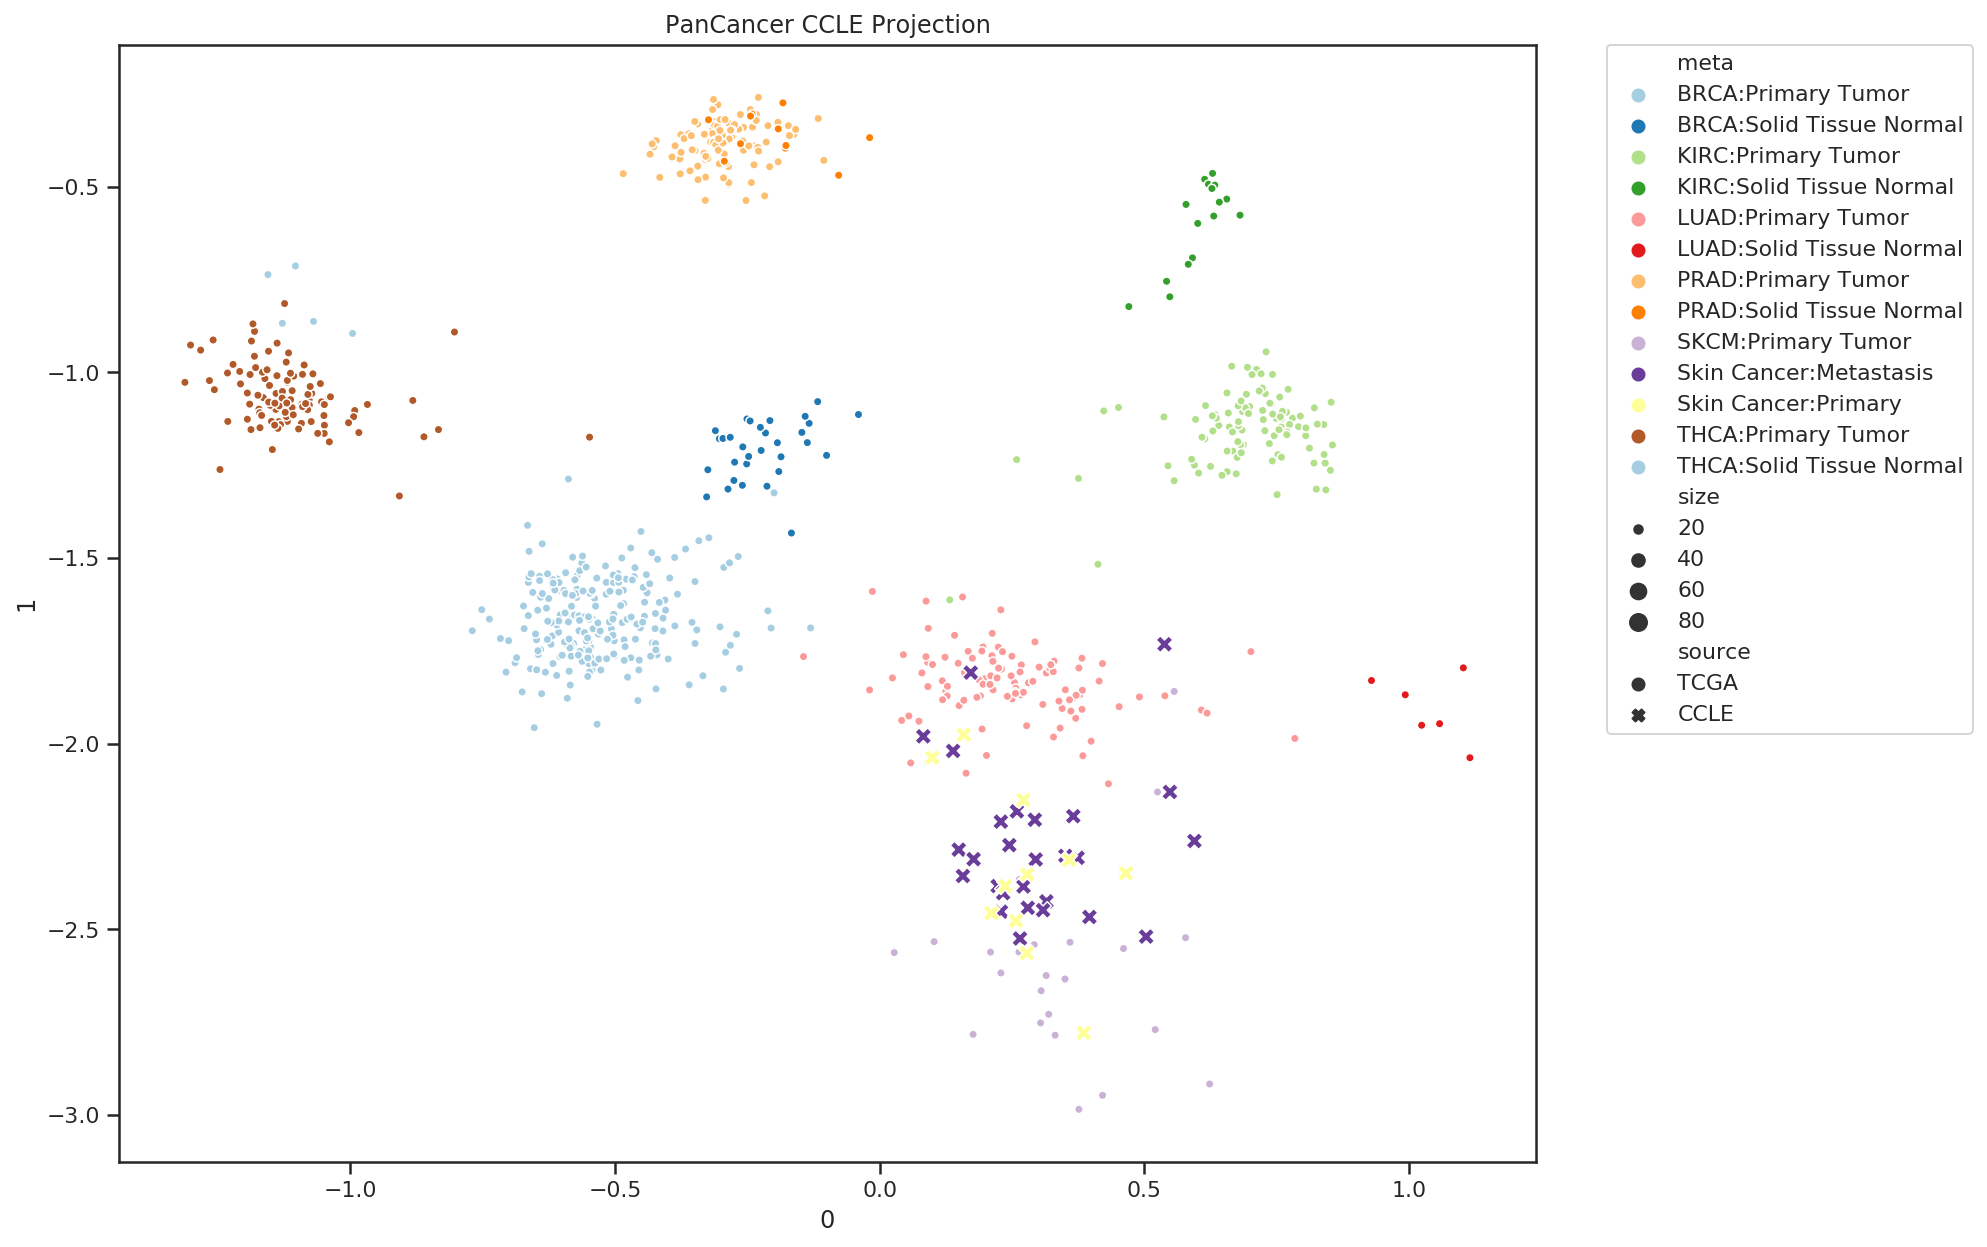

In [61]:
keep = ["Skin Cancer:Primary", "Skin Cancer:Metastasis"]
remove = np.setdiff1d(np.array(list(ccle_exp.holdout)), keep)
select_embeddings = all_embeddings[~all_embeddings['meta'].isin(remove)].sort_values(by='meta')

sns.scatterplot(x=0, y=1, hue='meta', style='source', palette='Paired', size='size', data=select_embeddings)
plt.title('PanCancer CCLE Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## L1000 Analysis

In [62]:
# reorder columns
lincs = lincs[tcga_down.columns]

In [63]:
lincs_norm = preprocess.transform(lincs)

In [64]:
lincs_norm.head()

pr_gene_symbol,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,ACD,ACLY,ACOT9,ADAM10,ADAT1,ADCK3,ADGRE5,ADGRG1,ADH5,ADI1,ADO,ADRB2,AGL,AKAP8,AKAP8L,AKR7A2,AKT1,ALAS1,ALDH7A1,ALDOA,ALDOC,AMDHD2,ANKRD10,ANO10,ANXA7,APBB2,APOE,APP,APPBP2,ARFIP2,ARHGAP1,ARHGEF12,ARHGEF2,ARID4B,ARID5B,ARL4C,ARNT2,ARPP19,ASAH1,...,TXNL4B,TXNRD1,UBE2A,UBE2C,UBE2J1,UBE2L6,UBE3B,UBE3C,UBQLN2,UBR7,UFM1,UGDH,USP1,USP14,USP22,USP6NL,USP7,UTP14A,VAPB,VAT1,VAV3,VDAC1,VGLL4,VPS28,VPS72,WASF3,WDR61,WDR7,WDTC1,WFS1,WIPF2,WRB,XBP1,XPNPEP1,XPO7,YKT6,YME1L1,YTHDF1,ZDHHC6,ZFP36,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
LJP005_A375_24H:A03,0.946543,0.425039,0.119077,0.746681,0.458438,0.130708,0.329497,0.542159,0.266488,0.434766,0.342716,0.509811,1.036403,0.740657,0.609402,0.251821,0.305142,0.579048,0.891661,0.810536,0.621045,0.203799,0.282855,0.215716,0.456032,0.263183,1.033882,0.674474,0.899630,0.432796,0.846718,0.541275,0.243512,0.461797,0.257518,0.534467,0.202765,0.066184,1.341065,0.176985,0.872359,0.790161,0.197787,0.649507,0.392200,0.216329,0.336038,0.736783,0.525817,0.162012,...,0.422883,1.125120,0.658992,1.277577,0.341276,0.748601,0.389285,0.769479,0.414882,0.734111,0.497252,0.491688,0.371266,0.221216,1.357305,0.278837,0.289138,0.698707,0.324197,0.812112,0.259084,0.217553,0.577342,0.143304,0.366535,0.160286,0.604568,0.194871,0.398004,0.176136,0.487183,0.195705,0.325113,0.398854,0.574778,0.781383,0.626207,0.427025,0.321444,0.552859,0.983613,0.702731,0.456674,0.343076,0.173796,0.472598,0.313697,0.188385,0.333136,0.657680
LJP005_A375_24H:A04,0.916650,0.407460,0.434207,0.717416,0.449039,0.142701,0.301590,0.712873,0.239427,0.393814,0.325239,0.406463,0.848752,0.758939,0.553176,0.233040,0.116384,0.627849,0.960706,0.912930,0.625127,0.197042,0.109695,0.203662,0.450377,0.250215,1.074047,0.658708,0.900225,0.440784,0.861111,0.541739,0.215807,0.452094,0.258809,0.544523,0.180422,0.072223,1.366400,0.169103,0.881294,0.773282,0.234700,0.612055,0.392196,0.225179,0.333858,0.784692,0.364077,0.219662,...,0.459501,1.132194,0.669963,1.278868,0.292688,0.733945,0.374431,0.880052,0.387123,0.724409,0.574990,0.474711,0.375461,0.216048,1.386369,0.466853,0.268933,0.752043,0.317418,0.824486,0.107814,0.731786,0.569750,0.146072,0.431681,0.163013,0.603245,0.196550,0.406064,0.230665,0.490427,0.183669,0.304909,0.385087,0.552659,0.794350,0.618371,0.384067,0.323290,0.532459,0.901077,0.608964,0.428368,0.343679,0.171629,0.466102,0.306674,0.202684,0.175156,0.574484
LJP005_A375_24H:A05,0.906254,0.420845,0.342993,0.748883,0.419818,0.126661,0.279817,0.520933,0.238574,0.301554,0.313961,0.554524,0.836839,0.602884,0.569314,0.267215,0.117253,0.506346,0.861706,0.890470,0.449168,0.698874,0.102410,0.203749,0.418996,0.231656,1.112940,0.684002,0.993631,0.416938,0.885840,0.513666,0.235368,0.464411,0.253240,0.552547,0.189886,0.071173,1.368655,0.165550,0.868680,0.770523,0.220185,0.647215,0.419202,0.208582,0.371421,0.806466,0.540240,0.241525,...,0.416320,1.166140,0.676561,1.318087,0.373359,0.735041,0.394228,0.842778,0.380649,0.774133,0.389369,0.434904,0.334080,0.231904,1.371514,0.252755,0.263139,0.735041,0.304324,0.794816,0.104665,0.162898,0.535127,0.168460,0.434904,0.147913,0.592395,0.211622,0.409494,0.178446,0.486559,0.190144,0.302247,0.344987,0.537869,0.739079,0.578120,0.395912,0.340772,0.592049,0.909154,0.579521,0.451360,0.360800,0.161037,0.533845,0.315102,0.232152,0.162101,0.575662
LJP005_A375_24H:A06,0.897711,0.374617,0.389820,0.736032,0.416309,0.160506,0.334638,0.560236,0.248128,0.297431,0.284260,0.507530,0.810851,0.685638,0.550871,0.251156,0.106558,0.542773,0.976651,0.808199,0.577253,0.202847,0.140221,0.194564,0.416309,0.259785,0.803918,0.713440,0.915915,0.407212,0.754598,0.543375,0.258585,0.547729,0.254376,0.506750,0.215249,0.083231,1.328002,0.173877,0.821048,0.766827,0.212530,0.642702,0.415284,0.233672,0.358092,0.774380,0.523773,0.207490,...,0.456825,1.138773,0.670912,1.242093,0.393847,0.776051,0.370153,0.809699,0.365310,0.633532,0.513904,0.479055,0.341106,0.253572

In [65]:
lincs_row.head()

,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id,clean_name,id_list
sig_id,,,,,,,,,
LJP005_A375_24H:A03,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A03|LJP005_A375_24H_X2_...,A375,"[LJP005_A375_24H_X1_B19:A03, LJP005_A375_24H_X..."
LJP005_A375_24H:A04,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A04|LJP005_A375_24H_X2_...,A375,"[LJP005_A375_24H_X1_B19:A04, LJP005_A375_24H_X..."
LJP005_A375_24H:A05,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A05|LJP005_A375_24H_X2_...,A375,"[LJP005_A375_24H_X1_B19:A05, LJP005_A375_24H_X..."
LJP005_A375_24H:A06,DMSO,DMSO,ctl_vehicle,A375,-666,24 h,LJP005_A375_24H_X1_B19:A06|LJP005_A375_24H_X2_...,A375,"[LJP005_A375_24H_X1_B19:A06, LJP005_A375_24H_X..."
LJP005_A375_24H:A07,BRD-K76908866,CP-724714,trt_cp,A375,10.0 um,24 h,LJP005_A375_24H_X1_B19:A07|LJP005_A375_24H_X2_...,A375,"[LJP005_A375_24H_X1_B19:A07, LJP005_A375_24H_X..."


In [84]:
# # visual GEX distribution inspection between LINCS and TCGA
# for i in lincs_norm.columns[:7]:
#     plt.hist(lincs_norm[i], label='LINCS')
#     plt.hist(train_data_norm[i], label='TCGA')
#     plt.show()

In [67]:
skbr3_meta = lincs_row[lincs_row['clean_name']=='SKBR3']
skbr3_meta.shape

(1514, 9)

In [68]:
# with pd.option_context('display.max_rows', None):
#     skbr3_meta['pert_iname'].value_counts()

In [69]:
skbr3_meta = skbr3_meta.reset_index()

In [70]:
skbr3_meta.head()

,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_idose,pert_itime,distil_id,clean_name,id_list
0,LJP005_SKBR3_24H:A03,DMSO,DMSO,ctl_vehicle,SKBR3,-666,24 h,LJP005_SKBR3_24H_X1_B17:A03|LJP005_SKBR3_24H_X...,SKBR3,"[LJP005_SKBR3_24H_X1_B17:A03, LJP005_SKBR3_24H..."
1,LJP005_SKBR3_24H:A04,DMSO,DMSO,ctl_vehicle,SKBR3,-666,24 h,LJP005_SKBR3_24H_X1_B17:A04|LJP005_SKBR3_24H_X...,SKBR3,"[LJP005_SKBR3_24H_X1_B17:A04, LJP005_SKBR3_24H..."
2,LJP005_SKBR3_24H:A05,DMSO,DMSO,ctl_vehicle,SKBR3,-666,24 h,LJP005_SKBR3_24H_X1_B17:A05|LJP005_SKBR3_24H_X...,SKBR3,"[LJP005_SKBR3_24H_X1_B17:A05, LJP005_SKBR3_24H..."
3,LJP005_SKBR3_24H:A06,DMSO,DMSO,ctl_vehicle,SKBR3,-666,24 h,LJP005_SKBR3_24H_X1_B17:A06|LJP005_SKBR3_24H_X...,SKBR3,"[LJP005_SKBR3_24H_X1_B17:A06, LJP005_SKBR3_24H..."
4,LJP005_SKBR3_24H:A07,BRD-K76908866,CP-724714,trt_cp,SKBR3,10.0 um,24 h,LJP005_SKBR3_24H_X1_B17:A07|LJP005_SKBR3_24H_X...,SKBR3,"[LJP005_SKBR3_24H_X1_B17:A07, LJP005_SKBR3_24H..."


In [71]:
skbr3_lincs = lincs_norm[lincs_norm.index.isin(skbr3_meta['sig_id'])]

In [72]:
skbr3_lincs.head()

pr_gene_symbol,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,ACD,ACLY,ACOT9,ADAM10,ADAT1,ADCK3,ADGRE5,ADGRG1,ADH5,ADI1,ADO,ADRB2,AGL,AKAP8,AKAP8L,AKR7A2,AKT1,ALAS1,ALDH7A1,ALDOA,ALDOC,AMDHD2,ANKRD10,ANO10,ANXA7,APBB2,APOE,APP,APPBP2,ARFIP2,ARHGAP1,ARHGEF12,ARHGEF2,ARID4B,ARID5B,ARL4C,ARNT2,ARPP19,ASAH1,...,TXNL4B,TXNRD1,UBE2A,UBE2C,UBE2J1,UBE2L6,UBE3B,UBE3C,UBQLN2,UBR7,UFM1,UGDH,USP1,USP14,USP22,USP6NL,USP7,UTP14A,VAPB,VAT1,VAV3,VDAC1,VGLL4,VPS28,VPS72,WASF3,WDR61,WDR7,WDTC1,WFS1,WIPF2,WRB,XBP1,XPNPEP1,XPO7,YKT6,YME1L1,YTHDF1,ZDHHC6,ZFP36,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
LJP005_SKBR3_24H:A03,0.594078,0.614342,0.293478,0.904092,0.525143,0.285988,0.273754,0.306125,0.908610,0.401534,0.342717,0.418718,0.982226,0.308722,0.415033,0.367068,0.140350,0.547349,0.937489,0.416198,0.480834,0.215225,0.068797,0.242381,0.324588,0.277328,0.553120,0.905521,1.377204,0.412114,0.852748,0.351866,0.332428,0.424702,0.240763,0.752282,0.456150,0.137790,1.758244,0.152804,0.815823,0.703832,0.393624,0.299821,0.343552,0.378622,0.478830,1.349807,0.389446,0.516402,...,0.261821,1.438819,0.660240,0.861615,0.567739,0.468936,0.584446,0.697991,0.330315,0.486820,0.626999,0.440739,0.348134,0.411334,0.847466,0.377008,0.282667,0.346678,0.579348,0.185847,0.154571,1.009834,0.497255,0.443387,0.522529,0.155831,0.358057,0.319684,0.238679,0.332850,0.815823,0.252034,1.174890,0.179227,0.375190,0.542400,0.434469,0.399957,0.209991,0.642287,1.055720,0.305258,0.678622,0.242381,0.203049,0.835542,0.376403,0.237983,0.345845,0.286210
LJP005_SKBR3_24H:A04,0.631755,0.638874,0.281640,0.968473,0.592564,0.259723,0.215141,0.252189,0.865729,0.308207,0.355748,0.312962,1.089925,0.318706,0.433790,0.294149,0.104619,0.555503,1.102005,0.470351,0.393344,0.206886,0.074538,0.231082,0.317358,0.237315,0.649580,1.018067,1.281732,0.369932,0.841455,0.377585,0.560807,0.455769,0.217008,0.791486,0.418966,0.209896,1.847192,0.134226,0.913135,0.679618,0.441270,0.309568,0.351844,0.302059,0.425649,1.220198,0.393344,0.471798,...,0.280940,1.513609,0.671364,0.940101,0.539421,0.361575,0.584331,0.758178,0.255425,0.483867,0.444246,0.312284,0.334418,0.382339,0.729995,0.362865,0.295184,0.447213,0.618362,0.202733,0.171997,1.152289,0.539421,0.446324,0.624585,0.163769,0.384865,0.297252,0.217381,0.265070,0.838054,0.266136,1.236344,0.254348,0.358342,0.545885,0.411318,0.415302,0.273565,0.529374,1.060997,0.304796,0.501421,0.235852,0.190551,0.790435,0.379490,0.220731,0.361575,0.395530
LJP005_SKBR3_24H:A05,0.729644,1.030324,0.531789,1.009206,0.483887,0.238291,0.247579,0.174617,0.885289,0.552826,0.542171,0.475744,0.964830,0.303510,0.374735,0.268419,0.166852,0.612693,0.999809,0.400188,0.483076,0.215217,0.100679,0.265396,0.375639,0.372017,0.420699,0.853015,1.276538,0.331290,0.866658,0.276435,0.313177,0.587421,0.232051,0.812683,0.370201,0.134025,1.693682,0.124195,0.719123,0.623332,0.383740,0.320366,0.304481,0.260338,0.375639,1.152402,0.275436,0.819084,...,0.250656,1.523479,0.633509,0.958796,0.439527,0.345827,0.483076,0.634556,0.296687,0.623684,0.408968,0.474107,0.271934,0.348152,0.866935,0.355095,0.222617,0.315579,0.488741,0.201328,0.280419,1.012318,0.604819,0.483076,0.460086,0.165737,0.346292,0.254744,0.204014,0.536801,0.755628,0.405465,1.357089,0.165737,0.384188,0.593981,0.405904,0.649443,0.339756,0.542936,1.049855,0.240363,0.626149,0.403709,0.183965,0.853575,0.347223,0.275436,0.333177,0.376993
LJP005_SKBR3_24H:A06,0.591167,0.626235,0.207147,0.908730,0.561241,0.280166,0.215936,0.328987,0.875425,0.195978,0.335020,0.307067,1.094517,0.367806,0.397905,0.306810,0.147296,0.842934,0.970729,0.494081,0.423461,0.185266,0.167054,0.219599,0.340269,0.310925,0.590197,0.935616,1.320833,0.402131,0.909013,0.337273,0.352163,0.391294,0.208001,0.792684,0.506824,0.112534,1.779925,0.146388,0.901077,0.692183,0.433730,0.302418,0.310925,0.360259,0.428038,1.340187,0.339021,0.486572,...,0.345242,1.422207,0.645526,0.953866,0.613418,0.349203,0.518781,0.691833,0.276984,0.396963,0.487218,0.349697,0.285973,0.37

In [73]:
skbr3_meta['pert_idose'].unique()

array(['-666', '10.0 um', '3.33 um', '1.11 um', '0.37 um', '0.12 um',
       '0.04 um'], dtype=object)

In [74]:
lincs_hierarchy = OrderedDict({'pert_iname':['lapatinib', 'neratinib', 'palbociclib', 'DMSO'],
                              'pert_idose':['10.0 um', '-666'],
                              'pert_itime':['24 h']})

In [75]:
# Define experiment
lincs_exp = Experiment(meta_data=skbr3_meta,
                      hierarchy=lincs_hierarchy,
                      index='sig_id',
                      cases='clean_name',
                      min_samples=0)

In [76]:
lincs_exp.labels_dict.values()

dict_values(['DMSO:-666:24 h', 'lapatinib:10.0 um:24 h', 'neratinib:10.0 um:24 h', 'palbociclib:10.0 um:24 h'])

In [77]:
lincs_exp.holdout(holdout=lincs_exp.labels_dict.values())

In [78]:
skbr3_data, skbr3_labels = lincs_exp.get_data(lincs_norm, subset="holdout", dtype=np.float32)
siamese_skbr3_dataset = SiameseDataset(data=skbr3_data,
                                         labels=skbr3_labels,
                                         train=True)

In [79]:
skbr3_embeddings_baseline, skbr3_labels_baseline = vis.extract_embeddings(siamese_skbr3_dataset.train_data, siamese_skbr3_dataset.labels, model)

In [80]:
skbr3_embeddings = pd.DataFrame(skbr3_embeddings_baseline, columns=[0, 1])
skbr3_embeddings['id'] = lincs_exp.holdout_meta.index.values
skbr3_embeddings['meta'] = lincs_exp.holdout_meta['meta'].values
skbr3_embeddings['source'] = np.repeat('LINCS', len(skbr3_embeddings))
skbr3_embeddings['size'] = np.repeat(70, len(skbr3_embeddings))

In [81]:
tl_embeddings = pd.concat([tcga_embeddings, skbr3_embeddings])
tl_embeddings.shape

(782, 6)

Text(0.5, 1.0, 'PanCancer LINCS Projection')

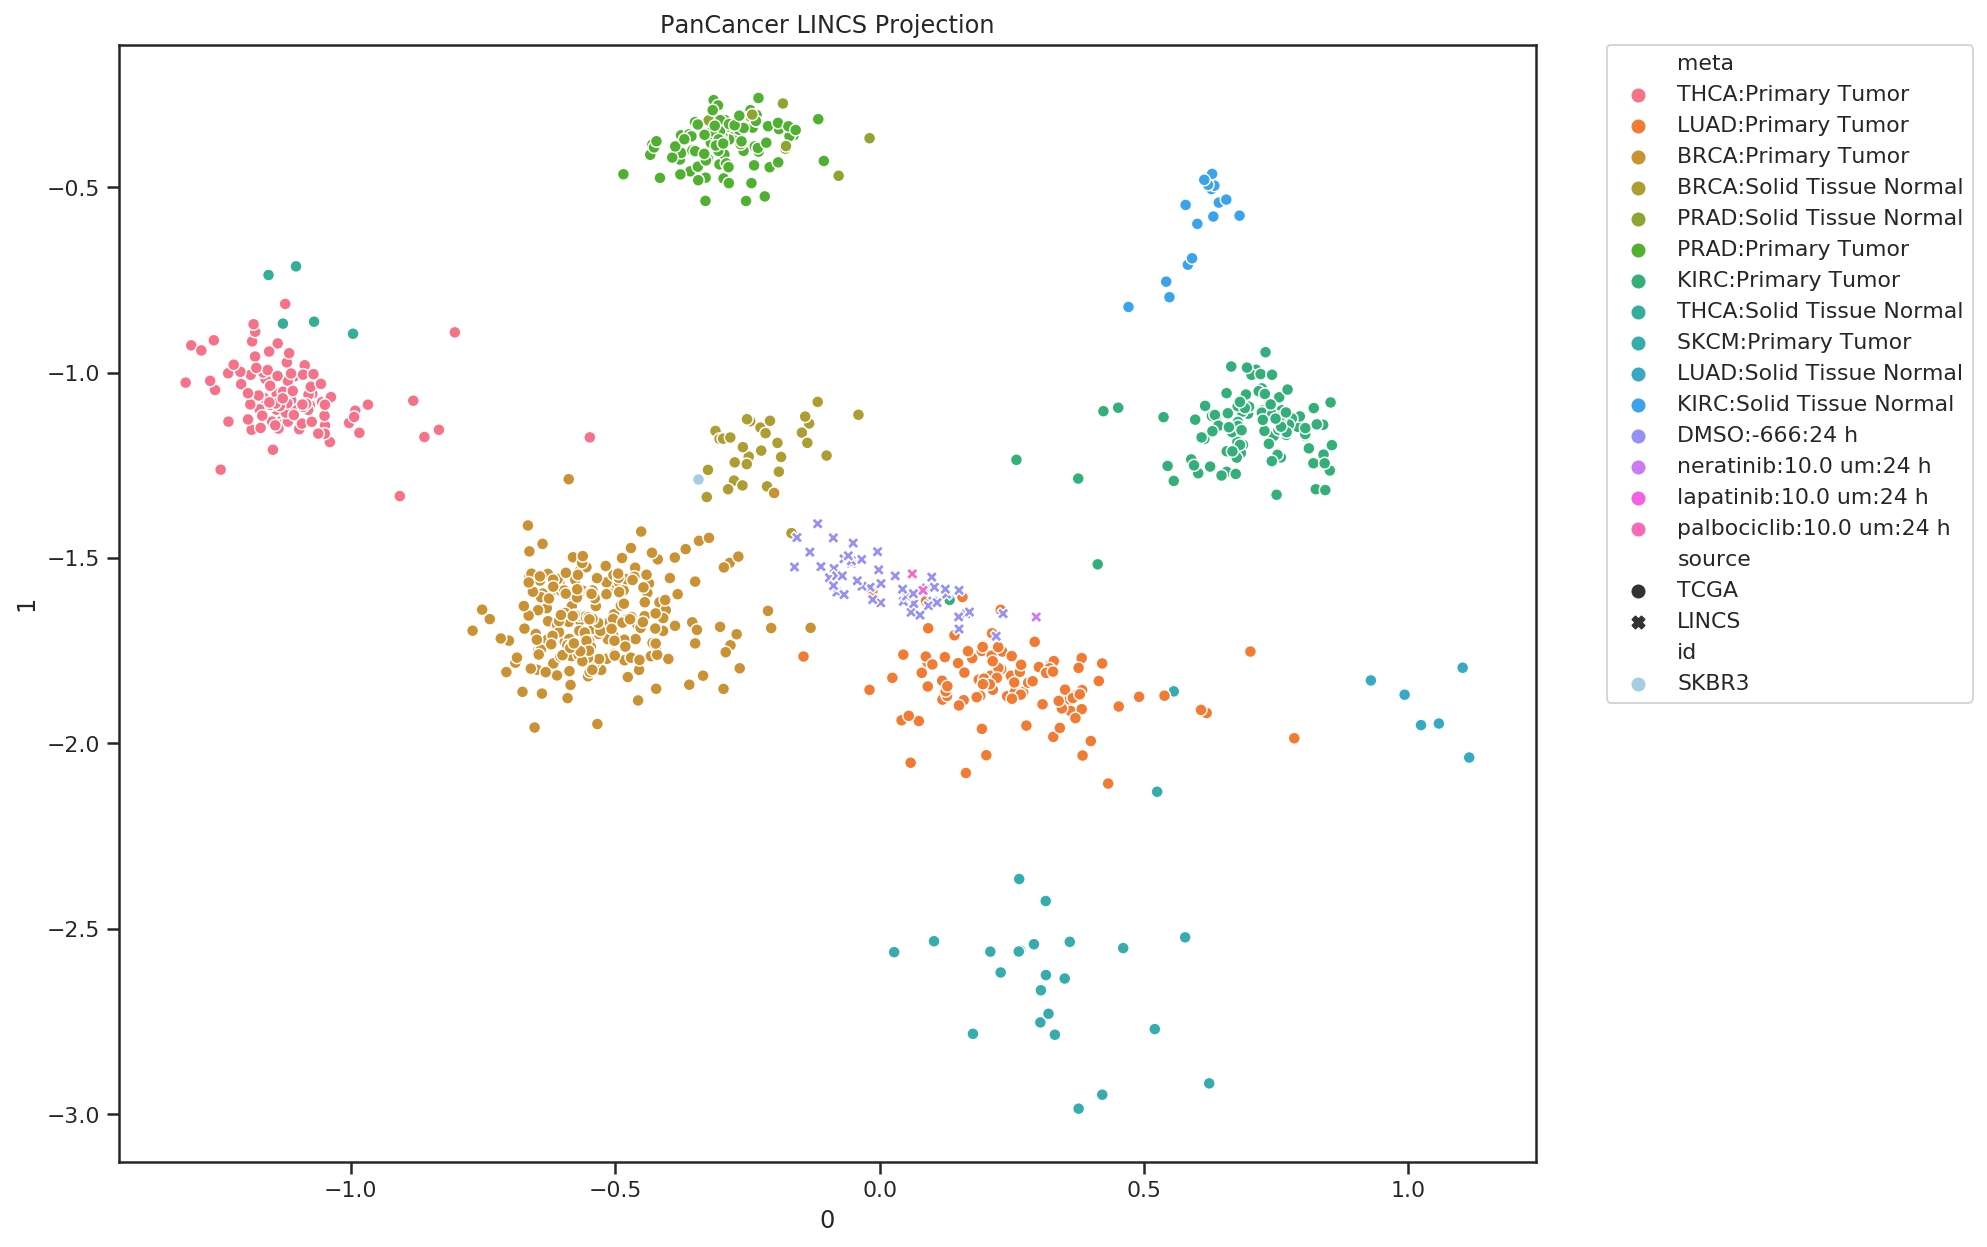

In [82]:
sns.scatterplot(x=0, y=1, hue='meta', style='source', data=tl_embeddings)
sns.scatterplot(x=0, y=1, hue='id', palette='Paired', data=ccle_embeddings[ccle_embeddings['id']=='SKBR3'])
#plt.plot(ccle_embeddings[ccle_embeddings['id']=='SKBR3'][0], ccle_embeddings[ccle_embeddings['id']=='SKBR3'][1], c='r')
plt.title('PanCancer LINCS Projection')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## LINCS Phase 3

In [85]:
lincsP3 = pd.read_pickle(os.path.join(base, ""))

pr_gene_symbol,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,ACBD3,ACD,ACLY,ACOT9,ADAM10,ADAT1,ADCK3,ADGRE5,ADGRG1,ADH5,ADI1,ADO,ADRB2,AGL,AKAP8,AKAP8L,AKR7A2,AKT1,ALAS1,ALDH7A1,ALDOA,ALDOC,AMDHD2,ANKRD10,ANO10,ANXA7,APBB2,APOE,APP,APPBP2,ARFIP2,ARHGAP1,ARHGEF12,ARHGEF2,ARID4B,ARID5B,ARL4C,ARNT2,ARPP19,ASAH1,...,TXNL4B,TXNRD1,UBE2A,UBE2C,UBE2J1,UBE2L6,UBE3B,UBE3C,UBQLN2,UBR7,UFM1,UGDH,USP1,USP14,USP22,USP6NL,USP7,UTP14A,VAPB,VAT1,VAV3,VDAC1,VGLL4,VPS28,VPS72,WASF3,WDR61,WDR7,WDTC1,WFS1,WIPF2,WRB,XBP1,XPNPEP1,XPO7,YKT6,YME1L1,YTHDF1,ZDHHC6,ZFP36,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
LJP005_A375_24H:A03,2074.000000,696.666687,166.333328,1460.000000,765.000000,183.666672,513.333313,946.666687,401.666656,716.333313,537.666687,874.666687,2392.666748,1443.333374,1104.000000,376.666656,469.333344,1031.666626,1893.000000,1643.000000,1132.333374,297.333344,430.000000,316.666656,760.000000,396.000000,2383.333252,1266.666626,1918.666626,712.333313,1752.000000,944.666687,362.666656,772.000000,386.333344,929.333313,295.666656,90.000000,3713.333252,254.666672,1831.666626,1583.333374,287.666656,1203.000000,631.666687,317.666656,525.333313,1432.666626,910.000000,231.333328,...,692.333313,2736.666748,1227.000000,3404.000000,535.000000,1465.333374,626.000000,1524.000000,676.333313,1425.333374,847.333313,835.333313,591.333313,325.666656,3795.666748,423.000000,441.000000,1330.000000,503.666656,1647.666626,389.000000,319.666656,1027.666626,202.666672,582.333313,228.666672,1092.333374,283.000000,643.000000,253.333328,825.666687,284.333344,505.333344,644.666687,1021.666687,1558.000000,1145.000000,700.666687,498.666656,971.000000,2202.000000,1340.666626,761.333313,538.333313,249.666672,794.666687,484.666656,272.666656,520.000000,1223.666626
LJP005_A375_24H:A04,1670.000000,559.666687,605.000000,1167.333374,630.666687,170.666672,391.666656,1157.000000,301.000000,537.000000,427.666656,558.000000,1487.333374,1264.000000,822.000000,292.000000,137.333328,972.000000,1795.333374,1659.666626,966.333313,242.333328,129.000000,251.333328,633.000000,316.333344,2144.333252,1037.333374,1624.666626,616.333313,1519.666626,800.000000,268.000000,636.000000,328.666656,805.333313,220.000000,83.333336,3250.333252,205.000000,1573.333374,1298.333374,294.333344,939.333313,534.333313,281.000000,441.000000,1326.000000,488.666656,273.333344,...,649.000000,2339.333252,1061.666626,2884.666748,378.333344,1205.333374,505.333344,1570.000000,526.000000,1183.333374,864.666687,676.000000,507.000000,268.333344,3338.333252,662.000000,343.333344,1247.666626,415.666656,1425.000000,126.666664,1200.333374,854.333313,175.000000,600.666687,197.000000,921.333313,241.666672,557.333313,288.666656,704.333313,224.333328,396.666656,522.666687,821.000000,1349.666626,952.333313,521.000000,424.666656,782.333313,1627.000000,933.000000,595.000000,456.333344,208.333328,660.666687,399.333344,250.000000,213.000000,863.666687
LJP005_A375_24H:A05,1573.000000,558.000000,436.333344,1188.666626,556.333313,144.000000,344.333344,729.000000,287.333344,375.333344,393.333344,790.333313,1396.000000,882.333313,818.000000,326.666656,132.666672,703.000000,1458.000000,1531.666626,604.666687,1078.666626,115.000000,241.000000,555.000000,278.000000,2179.000000,1047.000000,1814.000000,551.666687,1519.666626,716.000000,283.000000,630.333313,307.333344,786.666687,223.000000,78.666664,3124.666748,192.000000,1475.666626,1238.000000,262.666656,970.666687,555.333313,247.333328,479.666656,1322.333374,764.000000,291.333344,...,550.666687,2356.333252,1031.333374,2918.000000,482.666656,1157.666626,515.333313,1410.666626,494.000000,1246.333374,507.666656,581.000000,423.000000,278.333344,3136.666748,306.666656,321.000000,1157.666626,379.333344,1294.666626,117.666664,188.666672,754.666687,195.666672,581.000000,170.000000,862.000000,251.333328,539.666687,208.333328,668.333313,223.333328,376.333344,439.333344,759.666687,1166.666626,834.666687,518.000000,433.000000,861.333313,1580.666626,837.333313,608